<a href="https://colab.research.google.com/github/MuhammadSyarwaniRizki/221230015-Pengantar-ML/blob/main/221230015-Pengantar-ML/week-08/praktikum-3-visualisasi-data-WINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""
Analisis dataset Wine:
- Load dataset Excel
- Preprocessing (drop NA, non-numeric handling)
- Standardisasi
- PCA (n_components >= 3, contoh n_components=5)
- Visualisasi (explained variance, PC1 vs PC2, 3D PC1-PC2-PC3)
- Clustering: KMeans (n_clusters = jumlah kelas)
- Classification: RandomForest & SVM, tampilkan classification report & confusion matrix
- Siapkan teks presentasi ringkas
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_wine


In [2]:
# -------------------------
# 1. Load dataset
# -------------------------
# Load dataset
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
print(df['target'].value_counts())


target
1    71
0    59
2    48
Name: count, dtype: int64


In [3]:
# -------------------------
# 2. Identifikasi kolom target & pembersihan
# -------------------------
# Coba deteksi nama kolom target umum
possible_targets = ['Class', 'WineClass', 'Target', 'label', 'class', 'target']
target_col = None
for c in df.columns:
    if c in possible_targets:
        target_col = c
        break

# Jika tidak ditemukan, cari kolom integer dengan jumlah unik kecil
if target_col is None:
    for c in df.columns:

        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique() <= 10:
            target_col = c
            break

# Jika masih tidak ditemukan, pakai kolom terakhir
if target_col is None:
    target_col = df.columns[-1]

print(f"\nMenggunakan sebagai kolom target: '{target_col}'")

# Drop missing values
df_clean = df.dropna().reset_index(drop=True)
print("Ukuran setelah dropna:", df_clean.shape)

# Jika ada kolom non-numeric (kecuali target), drop dari fitur
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print("Menemukan kolom non-numeric, akan di-drop dari fitur:", non_numeric)
    X = X.select_dtypes(include=[np.number])


Menggunakan sebagai kolom target: 'target'
Ukuran setelah dropna: (178, 14)


In [4]:
# -------------------------
# 3. Standardisasi
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Standarisasi fitur selesai. Shape X_scaled:", X_scaled.shape)

# -------------------------
# 4. PCA (> 2 komponen), default n_components = 5 atau min(fitur,5)
# -------------------------
n_components = 5 if X_scaled.shape[1] >= 5 else X_scaled.shape[1]
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_cols = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols)
df_pca[target_col] = y.values

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)
explained_df = pd.DataFrame({
    "PC": pca_cols,
    "ExplainedVarianceRatio": explained,
    "Cumulative": cum_explained
})
print("\nExplained variance ratio per komponen:")
print(explained_df)

Standarisasi fitur selesai. Shape X_scaled: (178, 13)

Explained variance ratio per komponen:
    PC  ExplainedVarianceRatio  Cumulative
0  PC1                0.361988    0.361988
1  PC2                0.192075    0.554063
2  PC3                0.111236    0.665300
3  PC4                0.070690    0.735990
4  PC5                0.065633    0.801623


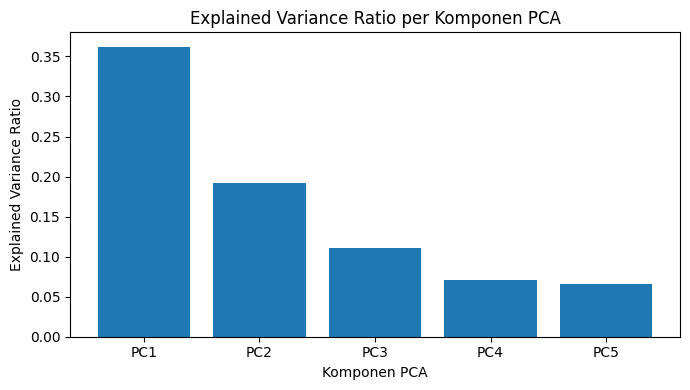

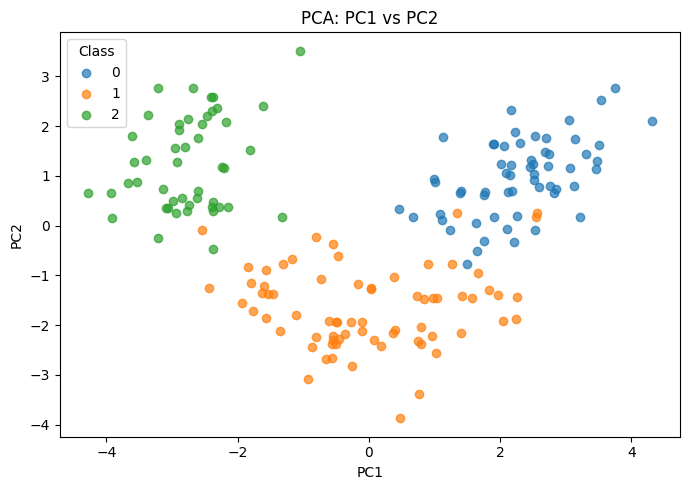

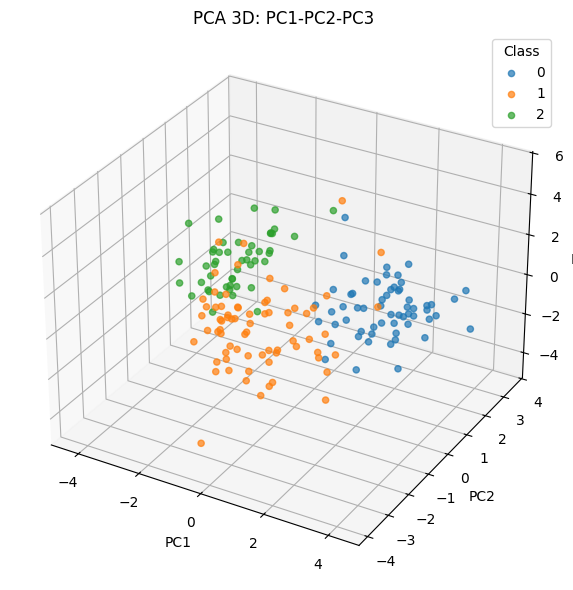

In [5]:
# -------------------------
# 5. Visualisasi PCA
# -------------------------
# 5a. Explained variance bar
plt.figure(figsize=(7,4))
plt.bar(range(1, n_components+1), explained, tick_label=pca_cols)
plt.title("Explained Variance Ratio per Komponen PCA")
plt.xlabel("Komponen PCA")
plt.ylabel("Explained Variance Ratio")
plt.tight_layout()
plt.show()

# 5b. Scatter PC1 vs PC2 (beri warna per kelas)
plt.figure(figsize=(7,5))
unique_labels = np.unique(y)
for lbl in unique_labels:
    mask = (y == lbl)
    plt.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'], label=str(lbl), alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: PC1 vs PC2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

# 5c. 3D scatter PC1-PC2-PC3 (jika ada >=3 komponen)
if n_components >= 3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    for lbl in unique_labels:
        mask = (y == lbl)
        ax.scatter(df_pca.loc[mask,'PC1'], df_pca.loc[mask,'PC2'], df_pca.loc[mask,'PC3'], label=str(lbl), alpha=0.7)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA 3D: PC1-PC2-PC3")
    ax.legend(title="Class")
    plt.tight_layout()
    plt.show()

In [6]:
# -------------------------
# 6. Clustering: KMeans
# -------------------------
n_clusters = len(unique_labels)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
ari = adjusted_rand_score(y, cluster_labels)
print(f"\nHasil KMeans: n_clusters={n_clusters}, Adjusted Rand Index (ARI) = {ari:.4f}")


Hasil KMeans: n_clusters=3, Adjusted Rand Index (ARI) = 0.8975



Random Forest Accuracy: 1.0000
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        12

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


SVM Accuracy: 0.9778
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.95      1.00      0.97        18
           2       1.00      0.92      0.96        12

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45


Model terbaik berdasarkan akurasi: RandomForest (accuracy=1.0000)


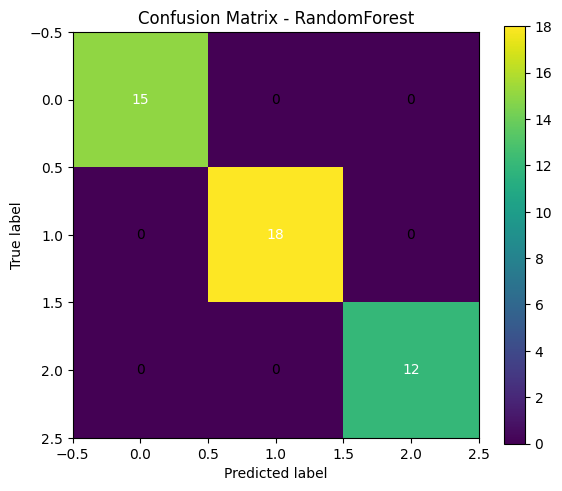

In [7]:
# -------------------------
# 7. Classification: RandomForest & SVM
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {acc_rf:.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# SVM (RBF)
svm = SVC(kernel='rbf', probability=False, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Accuracy: {acc_svm:.4f}")
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Pilih model terbaik berdasarkan accuracy
best_model_name = "RandomForest" if acc_rf >= acc_svm else "SVM"
best_pred = y_pred_rf if acc_rf >= acc_svm else y_pred_svm
best_acc = max(acc_rf, acc_svm)
print(f"\nModel terbaik berdasarkan akurasi: {best_model_name} (accuracy={best_acc:.4f})")

# Confusion matrix untuk model terbaik
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()